In [1]:
import numpy as np
from collections import OrderedDict
import logging

from IPython.display import display
%matplotlib inline

from astropy.io import fits
import astropy.wcs
from astropy import coordinates
import astropy.units as apu
from astropy import table

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import astropyp

alogger = logging.getLogger('astropyp.astrometry')
alogger.setLevel(logging.INFO)

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
sql = 'select * from decam_obs where expnum=442493'
exp_info = astropyp.db_utils.index.query(sql, idx_connect)
img_filename = exp_info[exp_info['PRODTYPE']=='image'][0]['filename']
img = fits.open(img_filename)
dqmask_filename = exp_info[exp_info['PRODTYPE']=='dqmask'][0]['filename']
dqmask = fits.open(dqmask_filename)

conv_filter = np.array([
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.173152, 0.369987, 0.636368, 0.881075, 0.982004, 0.881075, 0.636368, 0.369987, 0.173152],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531]
])
# SExtractor 'extract' detection parameters
sex_params = {
    'extract': {
        #'thresh': 1.5,# *bkg.globalrms,
        #'err':,
        #'minarea': 5, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    'thresh': 1.5
}
frame = 1
#img_data = hdulist[frame].data.byteswap(True).newbyteorder()
header = img[frame].header
wcs = astropy.wcs.WCS(header)
img_data = img[frame].data
dqmask_data = dqmask[frame].data
ccd = astropyp.phot.phot.SingleImage(header, img_data, dqmask_data,
        wcs=wcs, gain=4., exptime=30, aper_radius=8)
obj = 'SDSSJ1442'
from astropyp.wrappers.astromatic import ldac
sdss = ldac.get_table_from_ldac(
    '/media/data-beta/users/fmooleka/decam/catalogs/ref/{0}-SDSS9.fits'.format(obj))
e_ra = sdss['e_ra_J2015.4'].to('deg')
e_dec = sdss['e_dec_J2015.4'].to('deg')

In [2]:
min_flux = 1000
min_amplitude = 1000
good_amplitude = 100
calibrate_amplitude = 200
#ccd.detect_sources(sex_params, subtract_bkg=True, windowed=False)
ccd.detect_sources(sex_params, subtract_bkg=True)
ccd.select_psf_sources(min_flux,min_amplitude)
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
print "Good sources: {0}".format(np.sum(good_idx))
good_sources = ccd.catalog.sources[good_idx]

/media/data-beta/users/fmooleka/anaconda/envs/pyp27/lib/python2.7/site-packages/astropy/table/row.py:58: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
INFO:astropyp.phot.psf:Total sources: 489
INFO:astropyp.phot.psf:Sources with low flux: 113
INFO:astropyp.phot.psf:Sources with low amplitude: 424
INFO:astropyp.phot.psf:Sources with bad pixels: 178
INFO:astropyp.phot.psf:Elliptical sources: 91
INFO:astropyp.phot.psf:Source with close neighbors: 64
INFO:astropyp.phot.psf:Sources near an edge: 83
INFO:astropyp.phot.psf:Sources after cuts: 31


Good sources: 86


In [371]:
good_cat = astropyp.catalog.Catalog(good_sources)
refcat = astropyp.catalog.Catalog(sdss, ra='ra_J2015.4', dec='dec_J2015.4', 
                                  e_ra='e_ra_J2015.4', e_dec='e_dec_J2015.4')

crpix = [1024, 2048]
#crpix = [header['CRPIX1'],header['CRPIX2']]
cra, cdec = wcs.wcs_pix2world([crpix[0]],[crpix[1]],0)
crval = [cra[0],cdec[0]]

metric = astropyp.astrometry.AstrometricSolution(crpix=crpix, crval=crval, order=3)

ref_weights = 1/np.sqrt(e_ra**2+e_dec**2)

idx, matched = metric.get_solution(good_cat, refcat, ref_weights=ref_weights)

ra,dec = metric.pix2world(good_cat.x[matched],good_cat.y[matched])
ra.unit = 'deg'
dec.unit = 'deg'
print 'd_ra', np.mean(np.abs(ra-refcat.ra[idx][matched])*np.cos(np.deg2rad(np.array(dec)))).to('arcsec')
print 'd_dec', np.mean(np.abs(dec-refcat.dec[idx][matched])).to('arcsec')

c1 = coordinates.SkyCoord(ra, dec, unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched], refcat.dec[idx][matched], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print np.mean(separation)
print np.std(separation)
print 'rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

#pidx = good_cat['peak'][matched]>2000
pidx = good_cat['aper_flux'][matched]/good_cat['aper_flux_err'][matched]>200
c1 = coordinates.SkyCoord(ra[pidx], dec[pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])


x,y = metric.world2pix(ra, dec)
d2 = np.sqrt((x-good_cat.x[matched])**2 + (y-good_cat.y[matched])**2)
print 'cartesian mean', np.mean(d2)
print 'cartesian stddev', np.std(d2)
print 'cartesian rms', np.sqrt(np.sum(d2**2)/d2.shape[0])

INFO:astropyp.astrometry:formula: "ra ~ A_1_0+A_0_1+A_2_0+A_1_1+A_0_2+A_3_0+A_2_1+A_1_2+A_0_3"
INFO:astropyp.astrometry:formula: "dec ~ B_1_0+B_0_1+B_2_0+B_1_1+B_0_2+B_3_0+B_2_1+B_1_2+B_0_3"
INFO:astropyp.astrometry:formula: "x ~ Ap_1_0+Ap_0_1+Ap_2_0+Ap_1_1+Ap_0_2+Ap_3_0+Ap_2_1+Ap_1_2+Ap_0_3"
INFO:astropyp.astrometry:formula: "y ~ Bp_1_0+Bp_0_1+Bp_2_0+Bp_1_1+Bp_0_2+Bp_3_0+Bp_2_1+Bp_1_2+Bp_0_3"


 d_ra 0.0567137384037 arcsec
d_dec 0.0510677113445 arcsec
0.0837377arcsec
0.057339arcsec
rms 0.101487785677 arcsec
high SNR sources 42
high SNR 0.0653605arcsec
high SNR 0.0332807arcsec
high SNR rms 0.0733457869808 arcsec
cartesian mean 0.000121931855354
cartesian stddev 9.23832307189e-05
cartesian rms 0.000152977248858


In [23]:
referr = np.sqrt(sdss['e_ra_J2015.4']**2 + sdss['e_dec_J2015.4']**2)
print np.mean(referr)
print np.std(referr)
print np.sqrt(np.sum(referr**2)/referr.shape[0])

99.9911507307 mas
59.7251760483 mas
116.470283242 mas


In [355]:
get_transform_tbl = astropyp.astrometry.get_transform_tbl

def lnlike(params, tx_matrix, refcoord, referr):
    fit_params = np.array([params[:-3]])*1e-10
    p_bad, y_bad, v_bad = params[-3:]
    
    # Apply the fit to the model
    model = np.sum(np.multiply(fit_params, tx_matrix),1)
    
    # calculate the log likelihood given the model
    root2pi = np.sqrt(2*np.pi)
    var_good = referr**2
    var_bad = v_bad + var_good
    likelihood_good = 1./root2pi/referr*np.exp(-0.5*(refcoord-model)**2/var_good)
    likelihood_bad = 1./root2pi/np.sqrt(var_bad)*np.exp(-0.5*(refcoord-y_bad)**2/var_bad)
    return np.sum(np.log((1-p_bad)*likelihood_good + p_bad*likelihood_bad))

def lnprior(theta):
    """
    We use a uniform "uninformative" prior on the bad parameters
    """
    p_bad, y_bad, v_bad = theta[-3:]
    # Our main restriction is that p_bad and v_bad are greater than zero, 
    # and that most of the points shouldn't be bad
    if (0<=p_bad<1 and 0<=v_bad<100 and -10000<y_bad<10000):
        return 0.0
    return -np.inf

def lnprob(theta, transform_tbl, refcoord, referr):
    """
    Combine the likelihood probability with the prior
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, transform_tbl, refcoord, referr)

In [356]:
import emcee
# We just guess that 100 walkers will do
ndim, nwalkers = 13, 100
# We make a very rough and bad guess for the starting point
init_guess = np.array([v for k,v in metric.x2ra.items()]+[1e-11,1e-10,1e-10])*1e10
p0 = [init_guess + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

#Setup the known quantities
tbl = get_transform_tbl(good_cat.x[matched]-crpix[0], good_cat.y[matched]-crpix[1], 3)
test = tbl.as_array().view(dtype=float).reshape((len(tbl), len(tbl.colnames)))
test = np.hstack([np.ones((test.shape[0],1), dtype=float), test])
ra = np.array(refcat.ra[idx][matched])-crval[0]
ra_err = np.array(refcat.e_ra[idx][matched].to('deg'))

# EnsembleSampler is the main interface for emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
    args=[test, ra, ra_err])
# They recommend running a few burn-in steps to let the walkers explore the parameter space 
# and get settled in to the maximum density
pos, prob, state = sampler.run_mcmc(p0, 1000)
sampler.reset()
print 'Finished sample chain, now running real chain'
sampler.run_mcmc(pos, 1000);

Finished sample chain, now running real chain


In [357]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

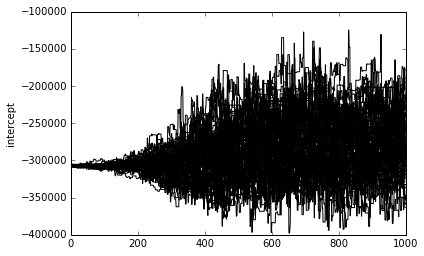

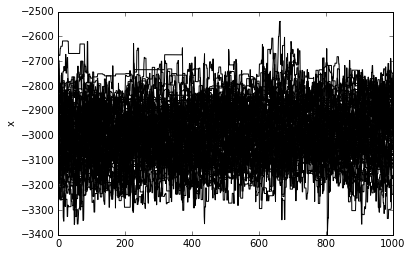

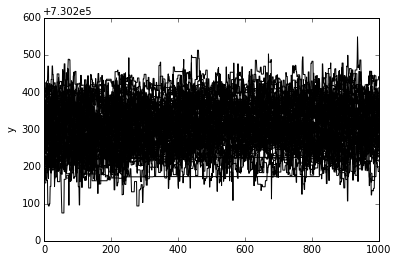

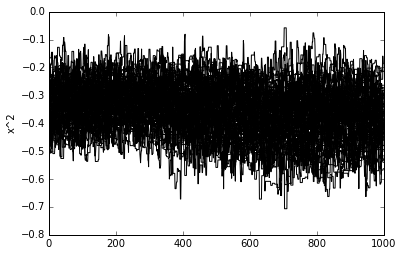

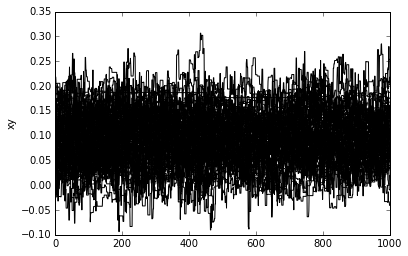

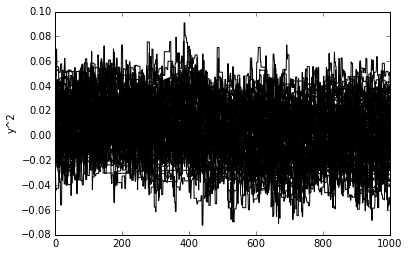

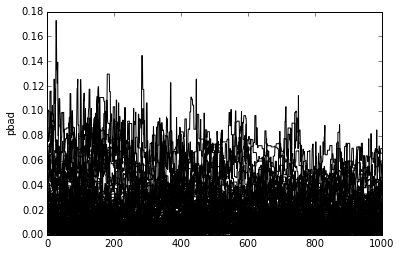

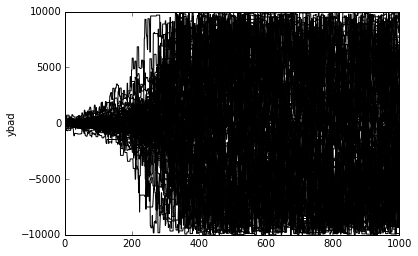

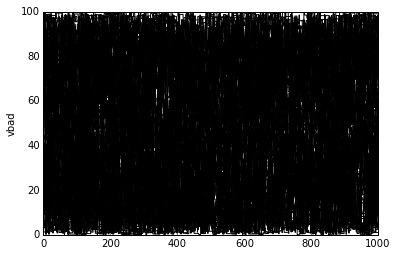

In [358]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

walker_x = np.array(range(1000))
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()
fig8, ax8 = plt.subplots()
fig9, ax9 = plt.subplots()

for w in range(nwalkers):
    chain = sampler.chain[w]
    i_chain = chain[:,0]
    x_chain =  chain[:,1]
    y_chain =  chain[:,2]
    x2_chain =  chain[:,3]
    xy_chain =  chain[:,4]
    y2_chain = chain[:,5]
    pbad_chain = chain[:,-3]
    ybad_chain = chain[:,-2]
    vbad_chain = chain[:,-1]
    
    ax1.plot(walker_x, i_chain, 'k-')
    ax2.plot(walker_x, x_chain, 'k-')
    ax3.plot(walker_x, y_chain, 'k-')
    ax4.plot(walker_x, x2_chain, 'k-')
    ax5.plot(walker_x, xy_chain, 'k-')
    ax6.plot(walker_x, y2_chain, 'k-')
    ax7.plot(walker_x, pbad_chain, 'k-')
    ax8.plot(walker_x, ybad_chain, 'k-')
    ax9.plot(walker_x, vbad_chain, 'k-')

ax1.set_ylabel('intercept')
ax2.set_ylabel('x')
ax3.set_ylabel('y')
ax4.set_ylabel('x^2')
ax5.set_ylabel('xy')
ax6.set_ylabel('y^2')
ax7.set_ylabel('pbad')
ax8.set_ylabel('ybad')
ax9.set_ylabel('vbad')
plt.show()

In [359]:
tr = [r[0]*1e-10 for r in result[:-3]]
#tr = init_guess[:-3].tolist()
tr

[-3.0000622053481605e-05,
 -2.9874969982608801e-07,
 7.3050864388374585e-05,
 -3.4872520092522315e-11,
 9.7168544494103429e-12,
 4.9311716079171058e-13,
 5.5294370972243177e-14,
 -1.0917280442009721e-15,
 1.1323781527516715e-14,
 6.8379056007711849e-17]

In [364]:
new_ra = np.sum(np.multiply(np.array([tr]),test),1)+crval[0]
np.mean((np.abs(ra+crval[0]-new_ra)*apu.deg).to('arcsec'))

<Quantity 0.056889343693455885 arcsec>

In [365]:
new_ra

array([ 220.04027942,  220.04112306,  220.04367771,  220.04395022,
        220.04538682,  220.04897599,  220.05395399,  220.07788688,
        220.09920319,  220.10486281,  220.10762045,  220.10917897,
        220.11033891,  220.11198252,  220.11346142,  220.11902315,
        220.12201698,  220.12580661,  220.13111364,  220.13362875,
        220.13508677,  220.13615743,  220.14395735,  220.14429171,
        220.14769808,  220.14986007,  220.15008848,  220.15015942,
        220.15705175,  220.15713346,  220.15956848,  220.16259873,
        220.16602339,  220.16952085,  220.17186976,  220.17274056,
        220.17761656,  220.17907975,  220.18873759,  220.1939037 ,
        220.19525587,  220.19773261,  220.20160399,  220.20282949,
        220.20609835,  220.20764965,  220.21479724,  220.21503493,
        220.21534418,  220.22720997,  220.22800444,  220.2289243 ,
        220.22879434,  220.2300911 ,  220.24030935,  220.24961251,
        220.251025  ,  220.25204716,  220.25276165,  220.25377